In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [3]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/root/.fastai/data/camvid/images'),
 PosixPath('/root/.fastai/data/camvid/valid.txt'),
 PosixPath('/root/.fastai/data/camvid/codes.txt'),
 PosixPath('/root/.fastai/data/camvid/labels')]

In [0]:
path_lbl = path/'labels'
path_img = path/'images'

In [5]:
fnames = get_image_files(path_img)
fnames[:20]

[PosixPath('/root/.fastai/data/camvid/images/0006R0_f03570.png'),
 PosixPath('/root/.fastai/data/camvid/images/Seq05VD_f03840.png'),
 PosixPath('/root/.fastai/data/camvid/images/0016E5_00510.png'),
 PosixPath('/root/.fastai/data/camvid/images/0016E5_08640.png'),
 PosixPath('/root/.fastai/data/camvid/images/0016E5_06000.png'),
 PosixPath('/root/.fastai/data/camvid/images/0016E5_04380.png'),
 PosixPath('/root/.fastai/data/camvid/images/0016E5_08023.png'),
 PosixPath('/root/.fastai/data/camvid/images/0016E5_05340.png'),
 PosixPath('/root/.fastai/data/camvid/images/0016E5_07500.png'),
 PosixPath('/root/.fastai/data/camvid/images/0001TP_006690.png'),
 PosixPath('/root/.fastai/data/camvid/images/0016E5_05910.png'),
 PosixPath('/root/.fastai/data/camvid/images/0006R0_f01650.png'),
 PosixPath('/root/.fastai/data/camvid/images/Seq05VD_f04680.png'),
 PosixPath('/root/.fastai/data/camvid/images/0001TP_008190.png'),
 PosixPath('/root/.fastai/data/camvid/images/0016E5_01020.png'),
 PosixPath('/root

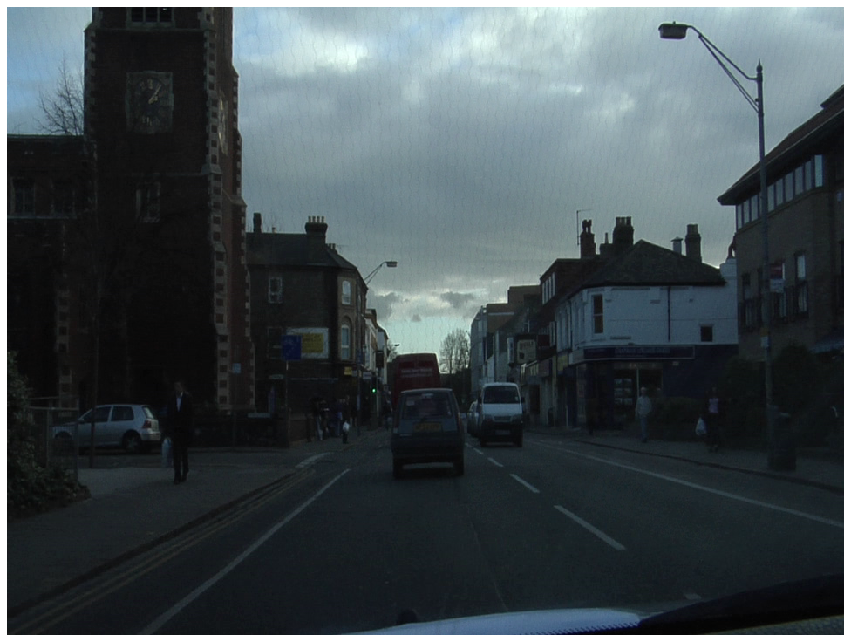

In [6]:
img_f = fnames[156]
img = open_image(img_f)
img.show(figsize=(15,20))

In [0]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

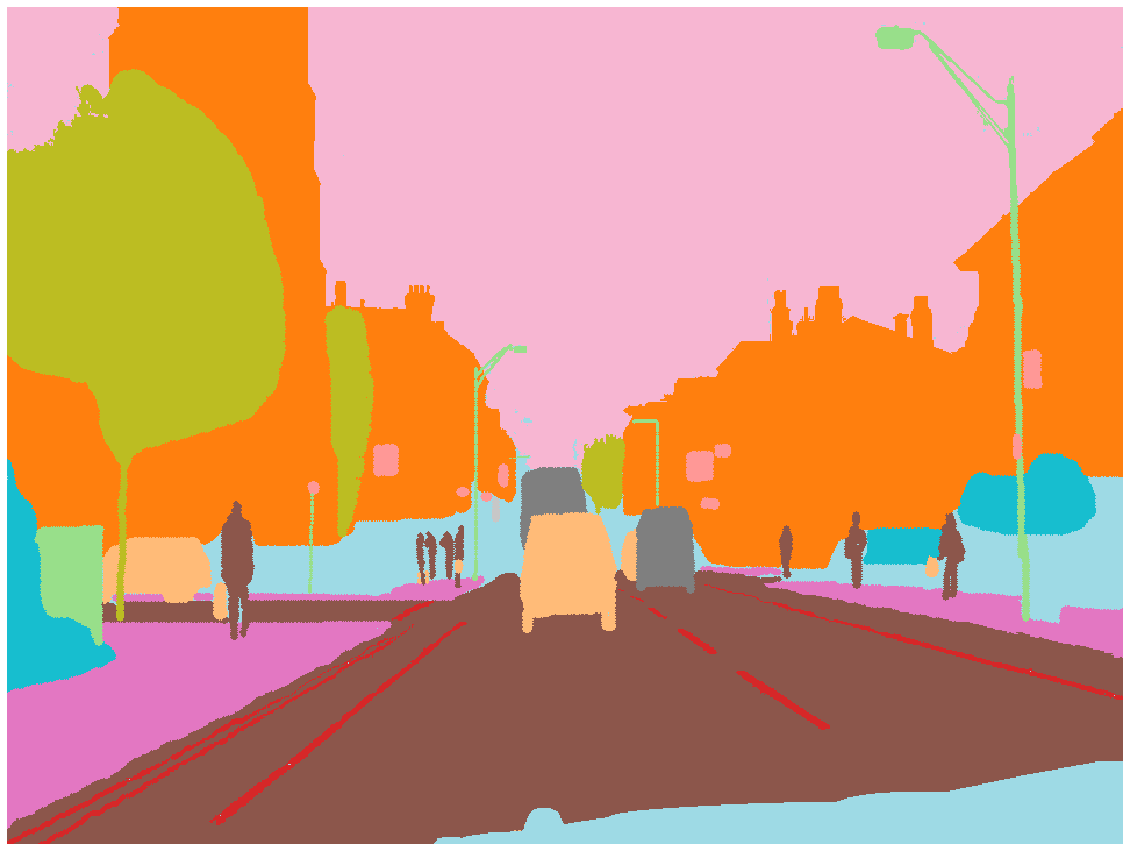

In [8]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(20,20), alpha=1)

In [9]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([720, 960]), tensor([[[21, 21, 21,  ..., 21, 21, 21],
          [21, 21, 21,  ..., 21, 21, 21],
          [21, 21, 21,  ..., 21, 21, 21],
          ...,
          [10, 10, 10,  ..., 30, 30, 30],
          [10, 10, 10,  ..., 30, 30, 30],
          [10, 10, 10,  ..., 30, 30, 30]]]))

In [10]:
codes = np.loadtxt(path/'codes.txt', dtype=str)
codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [11]:

size = src_size//2

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=8, have 16270MB of GPU RAM free


In [0]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [0]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)#bs
        .normalize(imagenet_stats))

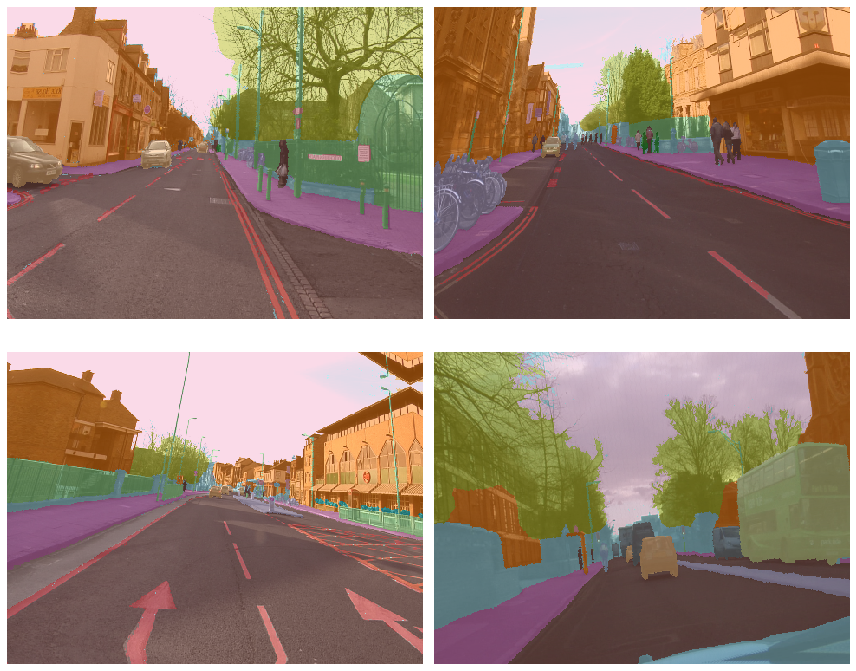

In [14]:
data.show_batch(2, figsize=(12,10))

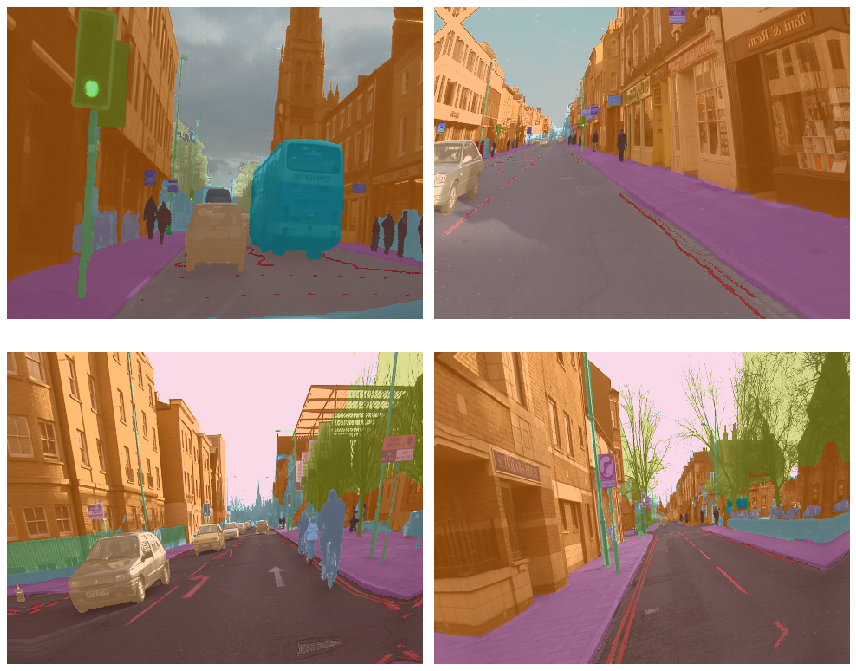

In [15]:
data.show_batch(2, figsize=(12,10))

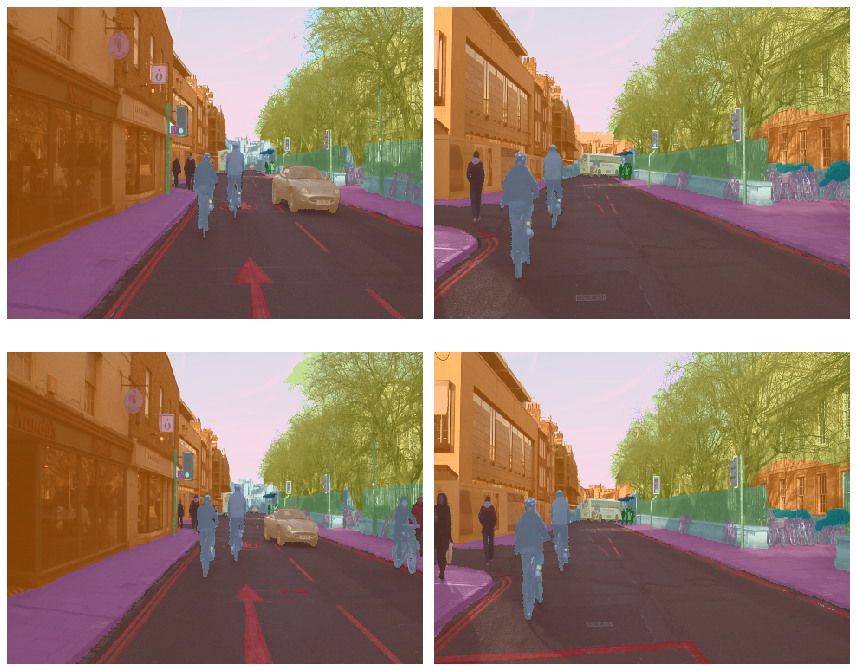

In [16]:
data.show_batch(2, figsize=(12,10), ds_type=DatasetType.Valid)

In [0]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [0]:
metrics=acc_camvid
# metrics=accuracy

In [0]:
wd=1e-3 #2

In [0]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


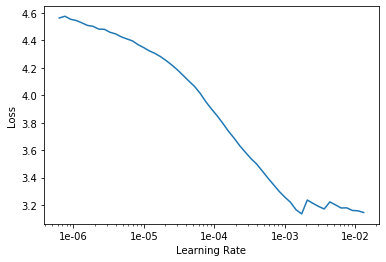

In [21]:
lr_find(learn)
learn.recorder.plot()

In [0]:
lr=3e-3

In [24]:
learn.fit_one_cycle(50, slice(lr), pct_start=0.9) #30

In [0]:
from fastai.vision import * 
from fastai import *
from fastai.callbacks import *
import scipy.ndimage

In [0]:
learn.save("segmentation-1")

In [0]:
learn.load('segmentation-1');

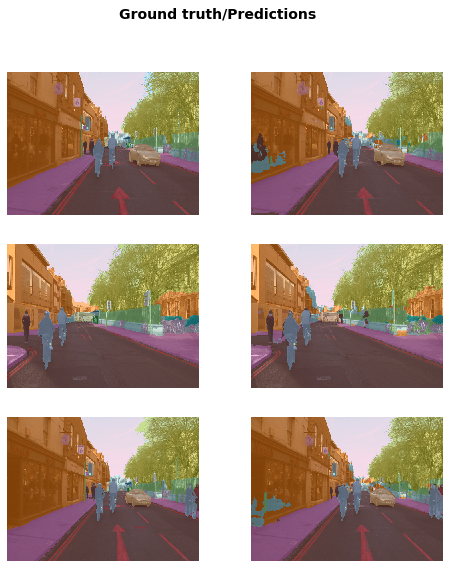

In [28]:
learn.show_results(rows=3, figsize=(8,9))

In [0]:
learn.unfreeze()

In [0]:
lrs = slice(lr/400,lr/4)

In [35]:
learn.fit_one_cycle(10, lrs, pct_start=0.8,)

In [0]:
learn.save("segmentation-2")

In [0]:
learn.load('segmentation-2');

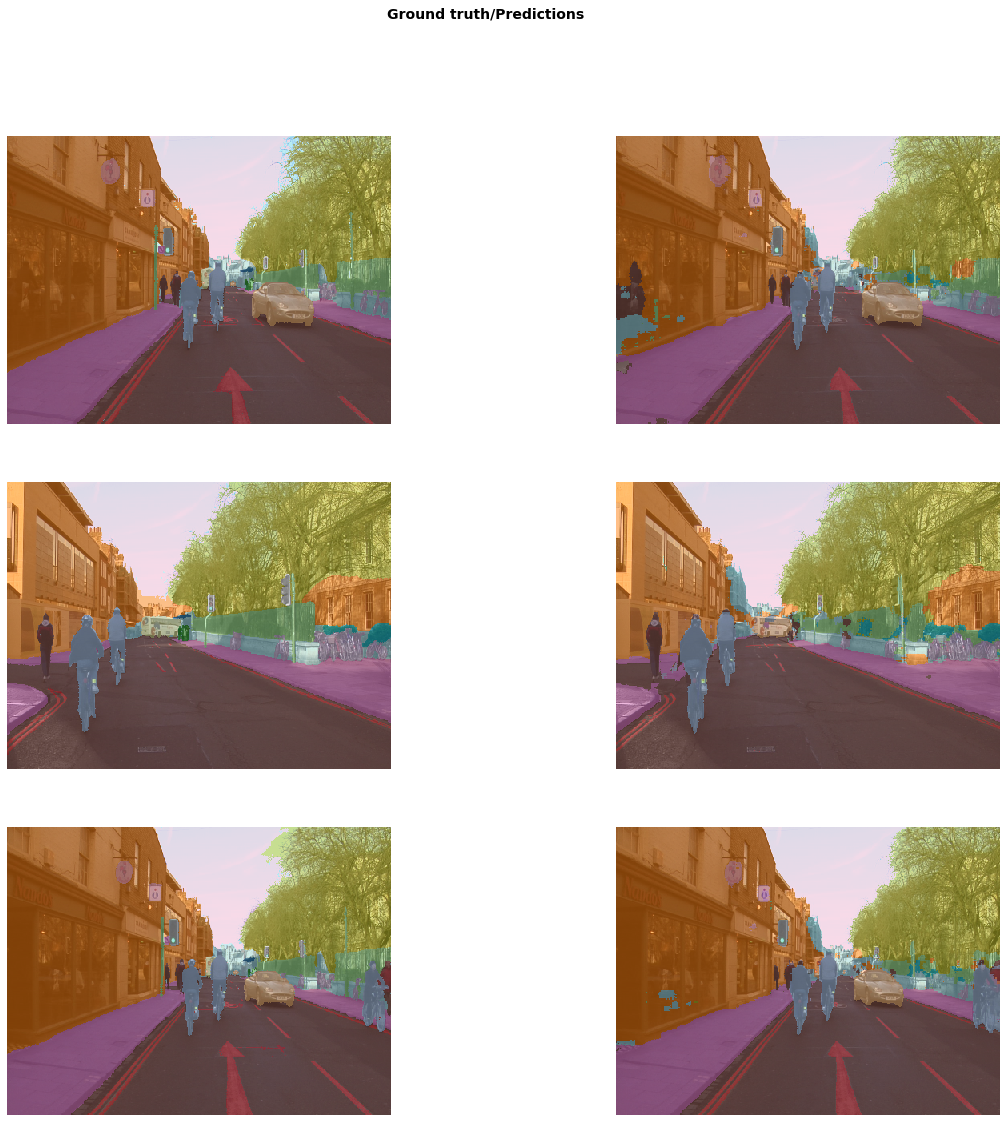

In [40]:
learn.show_results(rows=3, figsize=(20,18))